In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os

#os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/nachmz42/mediml/notebooks')

# Import libraries #

In [17]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt




# Load Data #

In [18]:
os.getcwd()

'/content/drive/MyDrive/nachmz42/mediml/notebooks'

In [20]:
import os

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))

test_dir = os.path.join(parent_dir, "raw_data", "chest_xray", "test")
train_dir = os.path.join(parent_dir, "raw_data", "chest_xray", "train")
val_dir = os.path.join(parent_dir, "raw_data", "chest_xray", "val")

In [ ]:
# Directories
#base_dir = "/Users/fabianwindhagen/code/nachmz42/raw_data/chest_xray"
#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'val')
#test_dir = os.path.join(base_dir, 'test')

# image preprocessing #

In [21]:
# Image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,         # Randomly zoom inside pictures
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)


val_datagen = ImageDataGenerator(rescale=1./255)

Found 4738 images belonging to 2 classes.


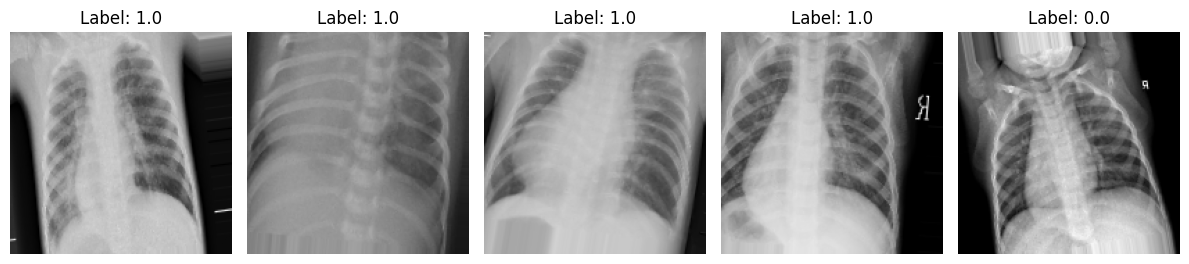

In [23]:
def visualize_augmented_images(train_datagen, directory, target_size=(150, 150), batch_size=32, num_images=5):
    # Setting up a generator with the provided datagen and directory
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(160, 160),  # resizing images
        batch_size=64,
        class_mode='binary')  # binary labels: pneumonia or no pneumonia

    # Fetching a batch of images and labels
    images, labels = next(train_generator)

    # Plotting the images
    plt.figure(figsize=(12, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Using the train_datagen with augmentations as discussed previously
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualizing the augmented images
visualize_augmented_images(augmented_datagen, train_dir)


In [24]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(160, 160),
        batch_size=64,
        class_mode='binary')

Found 4738 images belonging to 2 classes.


In [25]:
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(160, 160),
        batch_size=64,
        class_mode='binary')

Found 546 images belonging to 2 classes.


# Now lets try to build a simple model ##

In [26]:
model = Sequential()

# Add the pre-trained MobileNetV2 (without its top classification layer) as the base model
model.add(tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                            include_top=False,
                                            weights='imagenet'))

# Freeze the base model
model.layers[0].trainable = False

# Add the custom head
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))  # Dropout layer for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [27]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2914369 (11.12 MB)
Trainable params: 656

## Train the model ###

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr])



Epoch 1/100
74/74 [==============================] - 1355s 18s/step - loss: 0.2898 - accuracy: 0.8858 - val_loss: 0.5481 - val_accuracy: 0.7676 - lr: 0.0010
Epoch 2/100
74/74 [==============================] - 86s 1s/step - loss: 0.1501 - accuracy: 0.9420 - val_loss: 0.6681 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 3/100
74/74 [==============================] - 85s 1s/step - loss: 0.1304 - accuracy: 0.9497 - val_loss: 0.4042 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 4/100
74/74 [==============================] - 82s 1s/step - loss: 0.1297 - accuracy: 0.9504 - val_loss: 0.2792 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 5/100
74/74 [==============================] - 88s 1s/step - loss: 0.1318 - accuracy: 0.9478 - val_loss: 0.1752 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 6/100
74/74 [==============================] - 85s 1s/step - loss: 0.1300 - accuracy: 0.9467 - val_loss: 0.4852 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 7/100
74/74 [==============================] - 86s 1s/step - loss: 

In [30]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

## Test the model ###

In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=64,
    class_mode='binary')

Found 634 images belonging to 2 classes.


## evaluate ####

In [32]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test accuracy:", accuracy)

9/9 [==============================] - 74s 9s/step - loss: 0.2392 - accuracy: 0.8958
Test accuracy: 0.8958333134651184


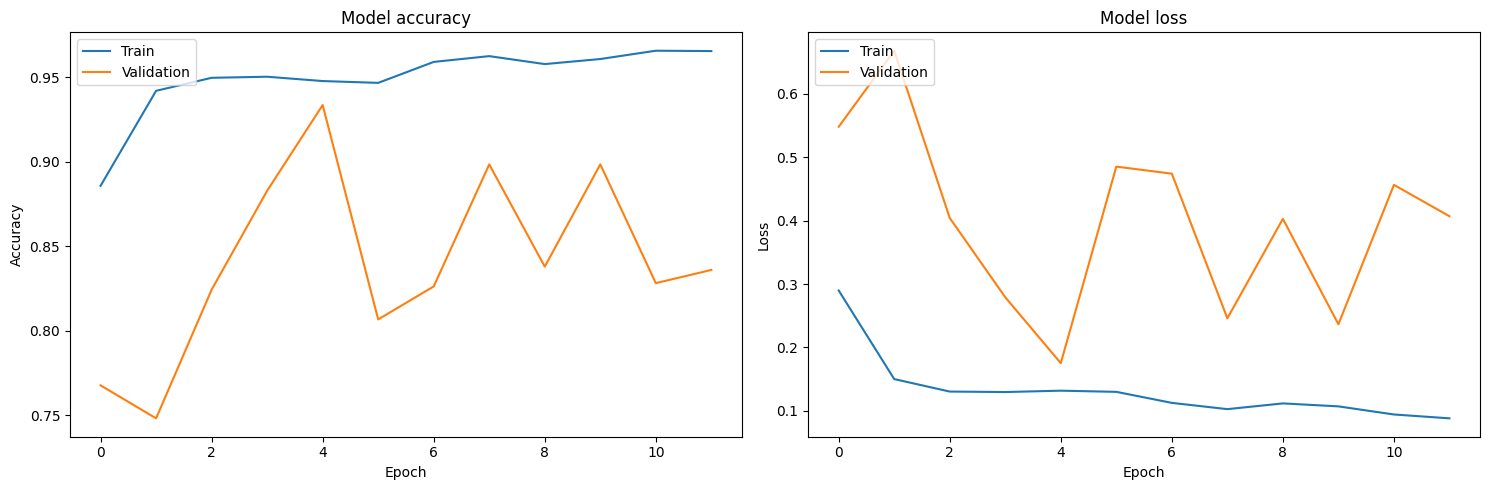

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')


    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


plot_training_history(history)


